# Cleaning the Data - Lipinksi's rule for the FDA New Chemical Entities (1997-2021)

After manually curated the dataset (merged from FDA database and DrugBank database) we are going the explore the Lipinski's rules of the ~560 New Chemical Entitities approved by the <b>FDA</b>. About 30 SMILES were manually gathered since none of the two strategies worked (SMILES from name structures or automatically merged with the DrugBank database).

First we need to import the libraries used in this analysis, which is mainly composed of rdkit (to manipulate the structures) and pandas/searborn to do the data analysis.

In [1]:
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
import session_info

import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.text import OffsetFrom
import matplotlib.pyplot as plt

## 1) Loading the and treating the dataset

Now, we load the database in the csv format. The database was converted to excel and carefully curated: each of the SMILES double checked, most  of the salts removed and was done by GHMS and ACGS.

In [2]:
# We read the raw data
drugs = pd.read_csv("../data/fda_small_molecules_smiles.csv")

# Selecting the dataframe without the index that came from the file
drugs = drugs.iloc[:,2:]
drugs.head(3)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug
1,imiquimod,NDA,1997,imiquimod,DB00724,approved; investigational,CC(C)CN1C=NC2=C1C1=C(C=CC=C1)N=C2N,Imiquimod,SmallMoleculeDrug
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug


In [3]:
print(drugs.shape)
drugs[(drugs["SMILES"] == "Not found")]

(560, 9)


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type
533,colesevelam hydrochloride,NDA,2000,colesevelam,DB00930,approved,Not found,Colesevelam,SmallMoleculeDrug
535,tinzaparin sodium,NDA,2000,tinzaparin,DB06822,approved,Not found,Tinzaparin,SmallMoleculeDrug
548,kunecatechins,NDA,2006,kunecatechins,DB01266,nutraceutical,Not found,Sinecatechins,SmallMoleculeDrug
551,gadofosveset trisodium,NDA,2008,gadofosveset,DB06705,contrast,Not found,Gadofosveset trisodium,SmallMoleculeDrug
556,sulfur hexafluoride lipid-type A microspheres,NDA,2014,sulfur hexafluoride lipid-type A microspheres,DB11104,approved,Not found,Sulfur hexafluoride,SmallMoleculeDrug
557,sodium zirconium cyclosilicate,NDA,2018,zirconium cyclosilicate,DB14048,approved,Not found,Sodium zirconium cyclosilicate,SmallMoleculeDrug


### 1.1) Initial cleaning and prep

First, we need to do some cleaning job on the dataset. We need to remove some of the salts  and do some double checking on the stuff. Now we perform the <b>SALT CLEANING</b> and the deionization of the respective base.

We begin by converting the SMILES into the mol format for further analysis

In [4]:
# correcting the Brilliant Blue G Ophthalmic Solution (it was unreadable)
brilliant_blue_smiles = '[Na+].CCOC1=CC=C(NC2=CC=C(C=C2)C(=C2\C=C/C(/C=C2C)=[N+](/CC)CC2=CC(=CC=C2)S([O-])(=O)=O)\C2=C(C)C=C(C=C2)N(CC)CC2=CC(=CC=C2)S([O-])(=O)=O)C=C1'

drugs.iloc[559,6] = brilliant_blue_smiles
drugs.iloc[559,:]

active_ingredient_moiety                 Brilliant Blue G Ophthalmic Solution
nda_bla                                                                   NDA
approval_year                                                            2019
active                                   Brilliant Blue G Ophthalmic Solution
DrugBank ID                                                           DB15594
Drug Groups                                                          approved
SMILES                      [Na+].CCOC1=CC=C(NC2=CC=C(C=C2)C(=C2\C=C/C(/C=...
Name                                                         Brilliant blue G
Drug Type                                                   SmallMoleculeDrug
Name: 559, dtype: object

In [5]:
# Removing the "Not Found" SMILES. The SMILES were almost all manually curated in order to gather as many structures as possible
drugs_db = drugs.loc[~(drugs["SMILES"] == "Not found")]
print(drugs_db.shape)
# Adding the ROMol Column, which is the proper format (mol) for further calculations
PandasTools.AddMoleculeColumnToFrame(drugs_db, "SMILES")

(554, 9)


RDKit ERROR: [15:44:51] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:44:51] Explicit valence for atom # 0 N, 4, is greater than permitted
/home/gustavo/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:422: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


Then, we make a function to clean the salts from the database. The selected ions were Cl, Br, Na, K and Gd (mainly from contrast structures)

In [6]:
# defining the salts we want to remove from the database
remover = SaltRemover(defnData="[Cl,Br,Na,K,Gd]")

# Defining the function to neutralize the atoms in organic molecules
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

In order to advance into the curation process we need to remove any non-readable or innappropriate smile/structure. We can do this and simutaneously stripping the salts using the function `StripMol()` that uses the `remover.SaltRemover()` function defined earlier.

In [7]:
mols = [] # creating an empty list

## FUNCTION FOR CHECKING THE NON READABLE:

# Creating a loop to 1) convert from smiles to mol and use the `remover.StripMol() on each structure
for i, smi in enumerate(drugs_db.SMILES):
    try:
        mol = Chem.MolFromSmiles(smi) # converting to a proper format
        mol = remover.StripMol(mol) # stripping the salts
        mols.append(mol) # appending to a list
    except:
        print(smi,i) # printing the exceptions, or the non-readable smiles and the respective index

RDKit ERROR: [15:45:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:45:01] Explicit valence for atom # 0 N, 4, is greater than permitted


[H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[Pt]11OC(=O)C(=O)O1 124


We can see that our database has some non-readable smiles that can cause some problems further in the future. We can remove the by doing the `drop()` method allied to `.index[]`.

In [8]:
drugs_db.shape

(554, 10)

In [9]:
# dropping the structures found to be non-readable
drugs_db = drugs_db.drop([drugs_db.index[124]]).reset_index(drop=True)

# dropping biotech molecule found manually
drugs_db = drugs_db.drop([drugs_db.index[304]]).reset_index(drop=True) #biological/polymer
drugs_db = drugs_db.drop([drugs_db.index[529]]).reset_index(drop=True) #biological/polymer
drugs_db = drugs_db.drop([drugs_db.index[526]]).reset_index(drop=True) #biological/polymer
drugs_db = drugs_db.drop([drugs_db.index[31]]).reset_index(drop=True) #talc

In [10]:
drugs_db.shape

(549, 10)







We can check again to see if any of the non-readable smiles still lingers on our dataset:

In [11]:
# Running the same function again (it's better to define a function and just call it again...)
mols = []
for i, smi in enumerate(drugs_db.SMILES):
    try:
        mol = Chem.MolFromSmiles(smi)
        mol = remover.StripMol(neutralize_atoms(mol))
        mols.append(mol)
    except:
        print(smi,i)

Since there is no structure printed, we can conclude that all the smiles left can be properly converted to mol. We are now able to perform the `remover.StripMol()` and `neutralize_atoms()` at our .mol column,

### 1.2) Removing the salts and neutralizing the organic molecules

Using the `apply` method on the column and performing the functions `StripMol` and `neutralize_atoms`

In [12]:
# removing the salts
drugs_db["Mol_Clean"] = drugs_db.ROMol.apply(remover.StripMol)
# neutralizing atoms O- goes to OH and so on..
drugs_db["Mol_Clean"] = drugs_db.Mol_Clean.apply(neutralize_atoms)

### 1.3) Calculation of the descriptors

We can see that our method cannot handle to much inorganic information such as the case of talc.

Now we calculate the descritptors: Molecular Weight, Number of Hydrogen Acceptors, Number of Hydrogen Donors and LogP that we need to compute the statistcs of the drugs. But first we need to transform the smiles to "mol" format.

In [13]:
drugs_db["mw"] = drugs_db["Mol_Clean"].apply(Descriptors.ExactMolWt)
drugs_db["n_hba"] = drugs_db["Mol_Clean"].apply(Descriptors.NumHAcceptors)
drugs_db["n_hbd"] = drugs_db["Mol_Clean"].apply(Descriptors.NumHDonors)
drugs_db["logp"] = drugs_db["Mol_Clean"].apply(Descriptors.MolLogP)

### Merging the dosage and route form dataset

In [14]:
# We begin by merging the drugs_db and the actives_route datasets in order to get the route
active_route = pd.read_csv("../data/active_route_final.csv")
active_route = active_route[["active_stripped", "Route_Unique"]]

Taking a look at the dataset we are able to see that everything seems ok we have to rename the active_stripped to active to merge both datasets.

In [15]:
print(f'The active_route dataset has the shape {active_route.shape}')

#Renaming the active_stripped column to active:
active_route.rename(columns = {"active_stripped": "active"}, inplace = True)

active_route.head(4)

The active_route dataset has the shape (856, 2)


,active,Route_Unique
0,abacavir,oral
1,abaloparatide,subcutaneous
2,abemaciclib,oral
3,abiraterone,oral


In [16]:
drugs_db_with_route = pd.merge(drugs_db, active_route, how = "left", on = "active")

drugs_db_with_route.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 0 to 548
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   active_ingredient_moiety  549 non-null    object 
 1   nda_bla                   549 non-null    object 
 2   approval_year             549 non-null    int64  
 3   active                    549 non-null    object 
 4   DrugBank ID               549 non-null    object 
 5   Drug Groups               549 non-null    object 
 6   SMILES                    549 non-null    object 
 7   Name                      545 non-null    object 
 8   Drug Type                 545 non-null    object 
 9   ROMol                     549 non-null    object 
 10  Mol_Clean                 549 non-null    object 
 11  mw                        549 non-null    float64
 12  n_hba                     549 non-null    int64  
 13  n_hbd                     549 non-null    int64  
 14  logp      

In [17]:
drugs_db_with_route[["active", "DrugBank ID", "Route_Unique"]].to_csv("../data/drugs_db_with_route.csv", index=False)

After creating the `drugs_db_with_route` we did some manually completion of the remaining route of administration and now we're going to import it and merge the remaining routes.

In [18]:
# We load the dataset 
drugs_db_with_route_manually = pd.read_csv("../data/drugs_db_with_route_manually_final.csv")

# Selecting only active and Route_Unique
drugs_db_with_route_manually = drugs_db_with_route_manually[["active", "Route_Unique"]]

# Renaming the Route_Unique to Route only
drugs_db_with_route_manually.rename(columns = {"Route_Unique": "route"}, inplace = True)

print(drugs_db_with_route_manually.shape)
drugs_db_with_route_manually.head(10)

(551, 2)


,active,route
0,troglitazone,oral
1,imiquimod,topical
2,anagrelide,oral
3,nelfinavir,oral
4,delavirdine,oral
5,tamsulosin,oral
6,toremifene,oral
7,tazarotene,topical
8,cerivastatin,oral
9,pramipexole,oral


### Merging the datasets route and SMILES and descriptors

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,ROMol,Mol_Clean,mw,n_hba,n_hbd,logp,route
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",441.160994,6,2,4.37426,oral
1,imiquimod,NDA,1997,imiquimod,DB00724,approved; investigational,CC(C)CN1C=NC2=C1C1=C(C=CC=C1)N=C2N,Imiquimod,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",240.137497,4,1,2.82270,topical
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",254.996617,3,1,1.92630,oral
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",567.313078,6,4,4.74762,oral
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",456.194360,6,3,2.71710,oral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,gadoterate meglumine,NDA,2013,gadoterate meglumine,DB09132,approved,[Gd+3].CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO....,Gadoteric acid,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",599.301387,14,10,-5.81190,intravenous
545,dimethyl fumarate,NDA,2013,dimethyl fumarate,DB08908,approved; investigational,[H]\C(=C(\[H])C(=O)OC)C(=O)OC,Dimethyl fumarate,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",144.042259,4,0,-0.11140,oral
546,dalbavancin,NDA,2014,dalbavancin,DB06219,approved; investigational,CN[C@H]1C(=O)N[C@@H]2Cc3ccc(Oc4cc5cc(Oc6ccc(cc...,Dalbavancin,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",1814.608558,29,21,4.16800,intravenous
547,tafamidis meglumine,NDA,2019,tafamidis meglumine,DB11644,approved; investigational,OC(=O)C1=CC=C2N=C(OC2=C1)C1=CC(Cl)=CC(Cl)=C1,Tafamidis,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",306.980298,3,1,4.49980,oral

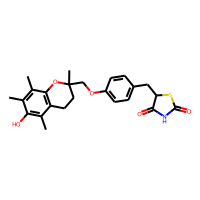
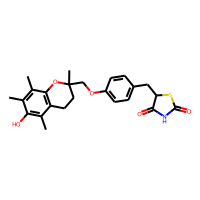
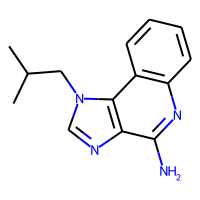
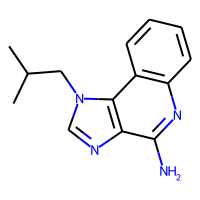
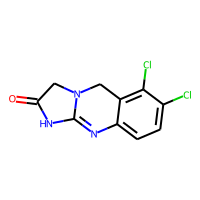
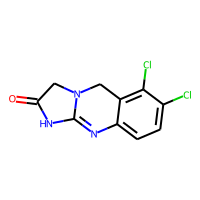
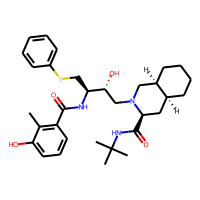
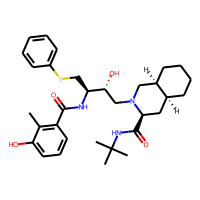
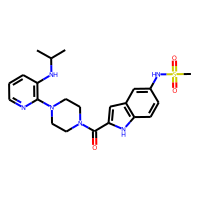
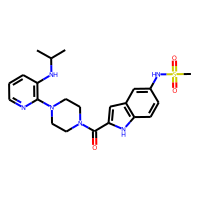
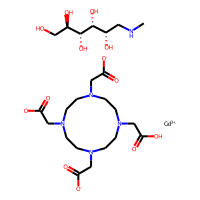
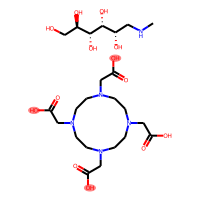
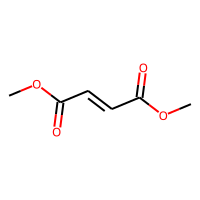
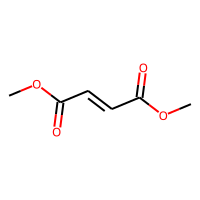
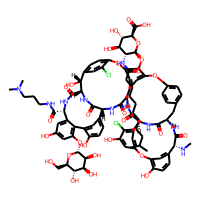
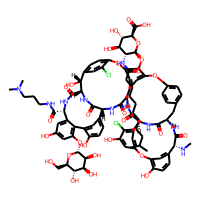
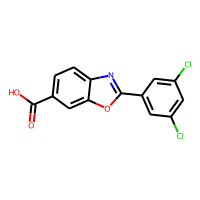
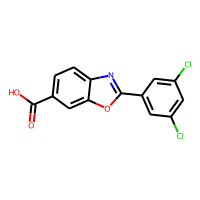
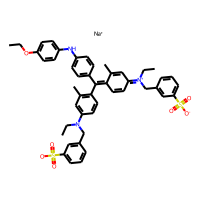
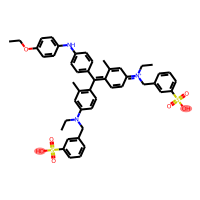

In [19]:
# Merging the datasets (with curated)
drugs_db_route_merged = pd.merge(drugs_db_with_route, drugs_db_with_route_manually, how = "left", on = "active")

# Dropping the Route_Unique columns that has 
drugs_db_route_merged = drugs_db_route_merged.drop(["Route_Unique"], axis = 1)

# Drugs 
drugs_db_route_merged

In [20]:
drugs_db_route_merged.shape

(549, 16)

,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,ROMol,Mol_Clean,mw,n_hba,n_hbd,logp,route
526,eptifibatide,NDA,1998,eptifibatide,DB00063,approved; investigational,NC(N)=NCCCCC1NC(=O)CCSSCC(NC(=O)C2CCCN2C(=O)C(...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",831.315614,11,10,-2.05440,NaN
529,unoprostone isopropyl,NDA,2000,unoprostone isopropyl,DBSALT001760,approved,CCCCCCCC(=O)CC[C@H]1[C@@H](C[C@@H]([C@@H]1C/C=...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",424.318875,5,2,5.12230,NaN
531,cefditoren pivoxil,NDA,2001,cefditoren pivoxil,DBSALT001811,approved,[H][C@]12SCC(\C=C/C3=C(C)N=CS3)=C(N1C(=O)[C@H]...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",620.118160,14,2,2.29812,NaN
535,pentetate calcium trisodium,NDA,2004,pentetate,DB06806,approved,[O-]C(=O)CN(CCN(CC([O-])=O)CC([O-])=O)CCN(CC([...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",393.138344,8,5,-2.68460,NaN

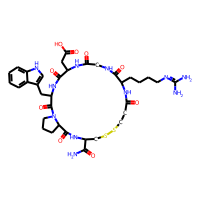
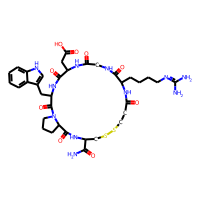
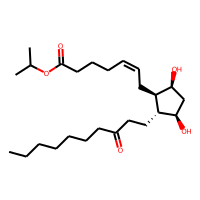
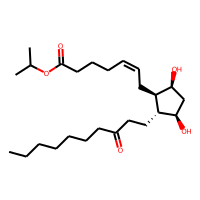
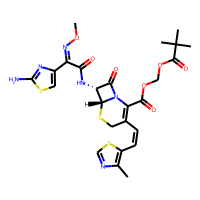
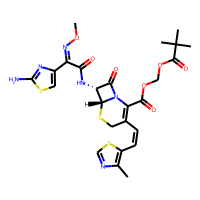
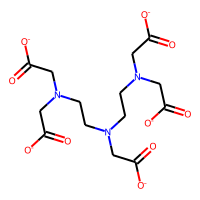
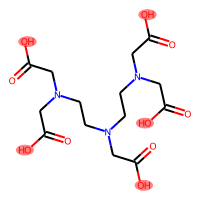

In [21]:
drugs_db_route_merged[drugs_db_route_merged["route"].isna()]

We complete manually the not-found routes as below:

In [22]:
drugs_db_route_merged.loc[529,"route"] = "intravenous"
drugs_db_route_merged.loc[533, "route"] = "ophthalmic"
drugs_db_route_merged.loc[535,"route"] = "oral"
drugs_db_route_merged.loc[539,"route"] = "intravenous"

### Removing the drug groups that has biological

In [23]:
biological = drugs_db_route_merged["Drug Groups"].str.contains(pat = "biological|polymer")
drugs_db_route_merged = drugs_db_route_merged[~biological].reset_index(drop = True)

In [24]:
drugs_db_route_merged.shape

(549, 16)

After removing the drugs that is in the biological groups we are left with 550 structures

### Creating DataFrame with only drugs with oral route of admninistration

There has been 360 FDA approved SMALL drugs with oral admnistration, from 1997 to 2021

(360, 16)


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,ROMol,Mol_Clean,mw,n_hba,n_hbd,logp,route
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",441.160994,6,2,4.37426,oral
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",254.996617,3,1,1.92630,oral
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",567.313078,6,4,4.74762,oral
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",456.194360,6,3,2.71710,oral
5,tamsulosin hydrochloride,NDA,1997,tamsulosin,DB00706,approved; investigational,CCOC1=CC=CC=C1OCCN[C@H](C)CC1=CC(=C(OC)C=C1)S(...,Tamsulosin,SmallMoleculeDrug,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",408.171893,6,2,2.34090,oral

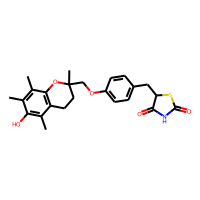
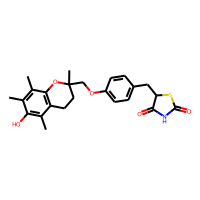
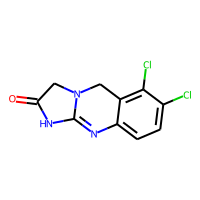
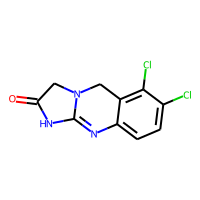
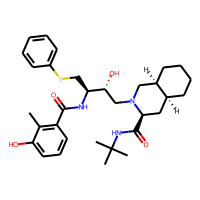
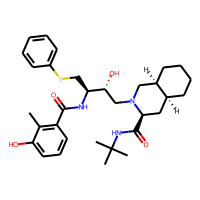
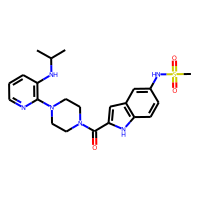
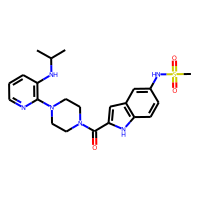
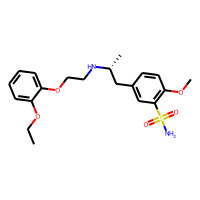
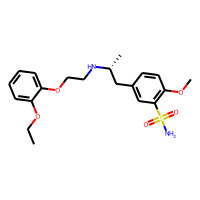

In [25]:
# separating the db
drugs_oral = drugs_db_route_merged[drugs_db_route_merged.route == 'oral'].copy()
print(drugs_oral.shape)
drugs_oral.head()

### Saving Dataset

In [26]:
drugs_db_route_merged.to_csv("../data/approved_drugs_final.csv", index=False)

In [27]:
session_info.show()